In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from fastai import *
from fastai.conv_learner import *
import torch 
from torch import nn
from torch.nn import functional as F

In [2]:
PATH='../../datasets/cifar/cifar_images/'

In [3]:
bs=256;

In [4]:
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [5]:
def data(sz,bs):
    tfms=tfms_from_stats(stats,sz,aug_tfms=transforms_side_on,pad=sz//8)
    md= ImageClassifierData.from_paths(PATH,bs=256,trn_name='trn',val_name='valid',tfms=tfms)
    return md

In [6]:
md=data(32,4)

In [83]:
dl=iter(md.trn_dl)
x,y=next(dl)

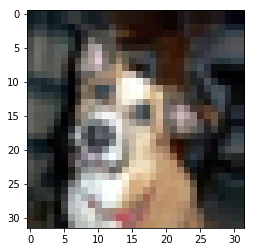

In [84]:
plt.imshow(md.trn_ds.denorm(x[0])[0])

In [85]:
lr=1e-2

In [97]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(nn.Linear(32*32*3,40),nn.ReLU(),nn.Linear(40,10),nn.LogSoftmax(dim=-1))
    def forward(self,x):
        inp=x.view(x.size(0),-1)
        return self.net(inp)

In [107]:
m=SimpleNet()

In [108]:
learn=ConvLearner.from_model_data(m,md)

In [109]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('ReLU-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 40]),
                           ('nb_params', 0)])),
             ('Linear-3',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)])),
             ('LogSoftmax-4',
              OrderedDict([('input_shape', [-1, 10]),
                           ('output_shape', [-1, 10]),
                           ('nb_params', 0)]))])

In [110]:
learn.lr_find()

 76%|███████▋  | 120/157 [00:40<00:12,  2.96it/s, loss=15.5]

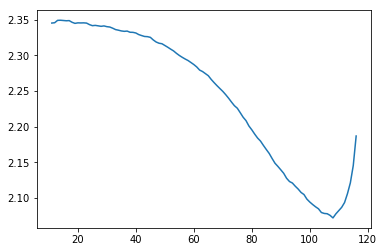

In [116]:
learn.sched.plot_loss()

In [119]:
learn.fit(1e-2,n_cycle=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.806335   1.691945   0.4056    
    1      1.712617   1.606445   0.425                      


[array([1.60644]), 0.425]

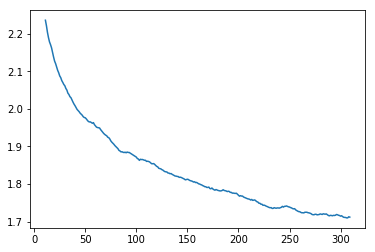

In [122]:
learn.sched.plot_loss()

In [124]:
class ConvNet(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers=nn.ModuleList(
            [nn.Conv2d(layers[i],layers[i+1],kernel_size=3,stride=2) for i in range(len(layers)-1)])
        self.pool=nn.AdaptiveAvgPool2d(1)
        self.out=nn.Linear(layers[-1],10)
    def forward(self,x):
        for l in self.layers: x=F.relu(l(x))
        x=self.pool(x)
        x=x.view(x.size(0),-1)
        return F.log_softmax(self.out(x),dim=-1)

In [125]:
learn=ConvLearner.from_model_data(ConvNet([3,20,40,80]),md)

In [126]:
learn.lr_find()

 87%|████████▋ | 136/157 [00:38<00:05,  3.56it/s, loss=1.07e+03]

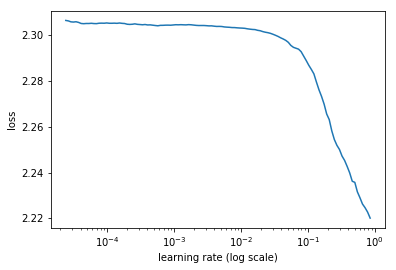

In [127]:
learn.sched.plot()

In [132]:
learn.fit(1e-1,2,cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.550139   1.47305    0.4674    
    1      1.52194    1.38695    0.4959                     
    2      1.394425   1.332806   0.5228                     


[array([1.33281]), 0.5228]

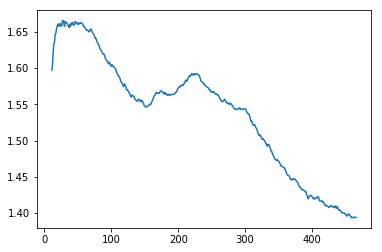

In [133]:
learn.sched.plot_loss()

In [26]:
class ConvLayer(nn.Module):
    def __init__(self,ni,nf):
        super().__init__()
        self.conv=nn.Conv2d(ni,nf,kernel_size=3,stride=2,padding=1)
    def forward(self,x):
        return F.relu(self.conv(x))

In [39]:
class Conv_net(nn.Module):
    def __init__(self,layers):
        super().__init__()
        
        self.layers=nn.ModuleList([ConvLayer(layers[i],layers[i+1]) for i in range(len(layers)-1)])
        self.out=nn.Linear(layers[-1],10)
        
    def forward(self,x):
        for l in self.layers: x=l(x)
        x= F.adaptive_avg_pool2d(x,1)
        x=x.view(x.size(0),-1)
        return F.log_softmax(self.out(x),dim=-1)

In [40]:
learn=ConvLearner.from_model_data(Conv_net([3,20,40,80]),md)

In [41]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
                 

In [42]:
learn.fit(1e-2,n_cycle=1)

epoch      trn_loss   val_loss   accuracy                   
    0      2.251021   2.204234   0.1811    



[array([2.20423]), 0.1811]

In [46]:
learn.lr_find()

 85%|████████▌ | 134/157 [00:41<00:07,  3.22it/s, loss=14.5]

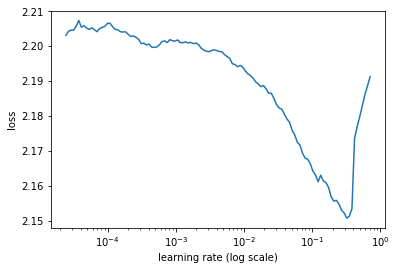

In [47]:
learn.sched.plot()

In [48]:
learn.fit(1e-1,n_cycle=2,cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.912124   1.827909   0.3286    
    1      1.720785   1.623034   0.4062                     


[array([1.62303]), 0.4062]

In [51]:
learn.fit(1e-1,n_cycle=2,cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.398593   1.310846   0.5236    
    1      1.385911   1.347511   0.5148                     
    2      1.271849   1.213539   0.5658                     


[array([1.21354]), 0.5658]

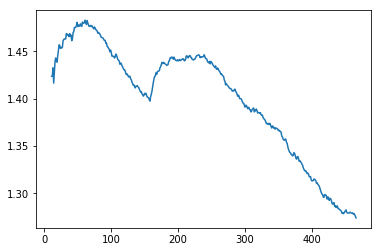

In [52]:
learn.sched.plot_loss()

In [112]:
# BatchNorm

In [104]:
class Bnlayer(nn.Module):
    def __init__(self,ni,nf,stride=2,kernel_size=3):
        super().__init__()
        self.conv=nn.Conv2d(ni,nf,kernel_size,stride,bias=False,
                           padding=1)
        self.a=nn.Parameter(torch.zeros(nf,1,1))
        self.m=nn.Parameter(torch.ones(nf,1,1))
    def forward(self,x):
        x=F.relu(self.conv(x))
        x_chan=x.transpose(0,1).contiguous().view(x.size(1),-1)
        if self.training:
            self.means=x_chan.mean(1)[:,None,None]
            self.std=x_chan.std(1)[:,None,None]
        return (x-self.means) / self.std *self.m +self.a

In [107]:
class ConvBnNet(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.conv1=nn.Conv2d(3,10,kernel_size=5,stride=1,padding=2)
        self.layers=nn.ModuleList([Bnlayer(layers[i],layers[i+1]) for 
                i in range(len(layers)-1)])
        self.out=nn.Linear(layers[-1],10)
    def forward(self,x):
        x=self.conv1(x)
        for l in self.layers: x=l(x)
        x=F.adaptive_avg_pool2d(x,1)
        x=x.view(x.size(0),-1)
        return F.log_softmax(self.out(x),dim=-1)

In [108]:
learn=ConvLearner.from_model_data(ConvBnNet([10,20,40,80,160]),md)

In [109]:
learn.lr_find()

 95%|█████████▍| 149/157 [02:19<00:07,  1.07it/s, loss=10.7]

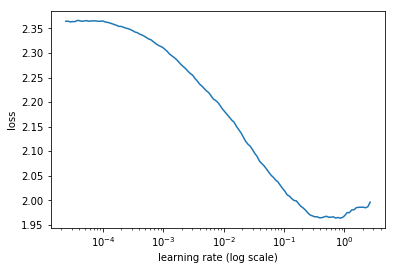

In [111]:
learn.fit(1e-1,3,cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.621801   1.513152   0.4437    
    1      1.454835   1.32827    0.5193                     
    2      1.321198   1.218848   0.5689                     


[array([1.21885]), 0.5689]

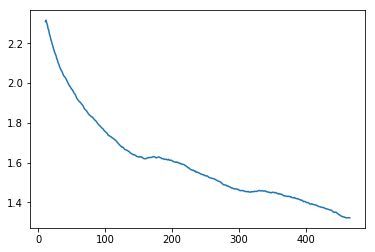

In [114]:
learn.sched.plot_loss()

In [113]:
class ResnetLayer(Bnlayer):
    def forward(x): x + super().forward(x)